In [10]:
import os
import statistics
import json
import glob
from matplotlib import pyplot as plt
from posixpath import basename
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
import matplotlib
import csv
import matplotlib.colors as mcolors

In [11]:
discr_dict={'P1':1,'P2':2,'P3':3,'P4':4,'Q1':5,'Q2':6}
# mesh_dict={"square_beam_0.5":0,"square_beam_0.25":1,"square_beam_0.1":2,"square_beam_0.05":3,"square_beam_0.025":4,"square_beam_0.01":5,"square_beam_0.005":6}
# mesh_dict={"square_beam_0.025":0,"square_beam_0.022":1,"square_beam_0.021":2,"square_beam_0.020":3,"square_beam_0.019":4,"square_beam_0.016":5,"square_beam_0.013":6,"square_beam_0.01":7}
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]
class Cal_result(object):
    # solver_name="AMGCL"
    # json_name="bar"
    # discr_order=1
    # n_ref=1
    # block_size=1
    # repeat_times=5
    # result_json=[]
    # time=np.zeros((1,repeat_times),dtype=np.double)
    # iter=np.zeros((1,repeat_times),dtype=np.int32)
    # err=np.zeros((1,repeat_times),dtype=np.double)
    def __init__(self,solver_name_,mesh_name_,json_name_,discr_order_,n_ref_,block_size_,repeat_times_,num_thread_,iter_step=1):
        self.solver_name=solver_name_
        self.mesh_name=mesh_name_
        self.json_name=json_name_
        self.discr_order=discr_order_
        self.n_ref=n_ref_
        self.block_size=block_size_
        self.repeat_times=repeat_times_
        self.num_thread=num_thread_
        self.cpu_usage=np.zeros((1,repeat_times_+1),dtype=np.double)
        self.peak_memory=0
        self.result_json=[None]*(repeat_times_+1)
        #From the json file
        self.mat_size=0
        self.nonzero=0
        self.time=np.zeros((1,repeat_times_+1),dtype=np.double)
        self.iter=np.zeros((1,repeat_times_+1),dtype=np.int32)
        self.err=np.zeros((1,repeat_times_+1),dtype=np.double)
        self.iter_step=iter_step

In [12]:
def get_erriter(solver_name_,json_data_): 
    #return iter,err(0 if not exist,-1 if fail)
    if solver_name_=="Eigen::CholmodSupernodalLLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1
    if solver_name_=="Eigen::ConjugateGradient":
        return json_data_["solver_iter"], json_data_["solver_error"]

    if solver_name_=="Eigen::PardisoLDLT" or solver_name_=="Eigen::PardisoLLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1
    if solver_name_=="Eigen::SimplicialLDLT":
        if json_data_["solver_info"]=="Success":
            return 0,0
        else:
            return -1,-1
    if solver_name_=="Catamari":
        return 0,0
    
    if ("num_iterations" in json_data_ ) and ("final_res_norm" in json_data_):
        return json_data_["num_iterations"],json_data_["final_res_norm"]
    else:
        raise Exception("Unknown json file format")



In [13]:
def stats(j_file_): 
    #return solving_time,iterations,error,mat_order
    with open(j_file_, 'r') as f:
        json_data = json.load(f)
    if "solver_type" in json_data["args"]:
        solver_name=json_data["args"]["solver_type"]
    else:
        solver_name=json_data["args"]["solver"]["linear"]["solver"]
    tensor_formulation=json_data["formulation"]
    mat_size=json_data["mat_size"]
    num_vertices=json_data["num_vertices"]
    nonzero=json_data["num_non_zero"]
    peak_memory=json_data["peak_memory"]
    time_solving=json_data["time_solving"]
    num_iterations=0
    err=0
    solver_info=json_data["solver_info"]
    if (tensor_formulation=="NeoHookean") or (tensor_formulation=="IncompressibleOgden") or (tensor_formulation=="MooneyRivlin") or (tensor_formulation=="SaintVenant") or (tensor_formulation=="UnconstrainedOgden"):
        err_list=[]
        iter_list=[]
        iter_steps=0
        for tmp_info in json_data["solver_info"]:
            for temp in tmp_info["info"]["internal_solver"]:
                tempiter,temperr=get_erriter(solver_name,temp)
                err_list.append(temperr)
                iter_list.append(tempiter)
            iter_steps+=tmp_info["info"]["iterations"]
        err=statistics.mean(err_list)
        num_iterations=sum(iter_list)
        # Need to verify the mat_order
        return time_solving,num_iterations,err,mat_size,nonzero,peak_memory,iter_steps
    else:
        tempiter,temperr=get_erriter(solver_name,solver_info)
        return time_solving,tempiter,temperr,mat_size,nonzero,peak_memory,1
    # Add "if" for more problems                

In [14]:
def read_cpu_usage(file):
    with open(file, "r") as f:
        lis = [line.split() for line in f] 
        l=len(list(enumerate(lis)))
        if(l==0):
            return -1
        else:
            usage=[]
            for i, line in enumerate(lis):
                if len(line)>4:
                    usage.append(float(line[-4])/100)
            return np.amax(usage)          

# Prepare data

In [15]:
def data_collect(path_lists,start_index):
    result_list=[]
    fail_list=[]
    for path_list in path_lists:
        for path in path_list:
            temp_path=path.split('/')
            solver_name=temp_path[0+start_index]
            mesh_name=temp_path[1+start_index]
            json_name=temp_path[2+start_index]
            discr_order=discr_dict[temp_path[3+start_index]]
            n_ref=int(temp_path[4+start_index][-1])
            block_size=int(temp_path[5+start_index][-1])
            if len(temp_path)==7+start_index:
                num_thread=int(temp_path[6+start_index].strip("Thread"))
            else:
                num_thread=-1
            repeat_path=glob.glob(os.path.join(path,"*"))
            repeat_times=max(map(int,map(os.path.basename,repeat_path)))
            temp_result=Cal_result(solver_name,mesh_name,json_name,discr_order,n_ref,block_size,repeat_times,num_thread)
            exist_bool=True
            for inner_path in repeat_path:
                repeat_time=int(os.path.basename(inner_path))
                json_path=os.path.join(inner_path,"json","result.json")
                cpu_path=os.path.join(inner_path,"output","cpu.txt")
                if os.path.exists(cpu_path):
                    if os.path.exists(json_path):
                        temp_result.time[0,repeat_time],temp_result.iter[0,repeat_time],temp_result.err[0,repeat_time],\
                            temp_result.mat_size,temp_result.nonzero,temp_result.peak_memory,temp_result.iter_step=stats(json_path)
                        temp_result.result_json[repeat_time]=inner_path
                        temp_result.cpu_usage[0,repeat_time]=read_cpu_usage(cpu_path)
                    else:
                        fail_list.append(inner_path)
                        # print(inner_path+" is empty, corresponding test failed")
                        exist_bool=False
                else:
                    if os.path.exists(json_path):
                        temp_result.time[0,repeat_time],temp_result.iter[0,repeat_time],temp_result.err[0,repeat_time],\
                            temp_result.mat_size,temp_result.nonzero,temp_result.peak_memory,temp_result.iter_step=stats(json_path)
                        temp_result.result_json[repeat_time]=inner_path
                        temp_result.cpu_usage[0,repeat_time]=0
                    else:
                        fail_list.append(inner_path)
                        # print(inner_path+" is empty, corresponding test failed")
                        exist_bool=False                    
            if exist_bool:
                result_list.append(temp_result)
    return result_list,fail_list

In [16]:
def df_create(result_list):
    columns=["Scene","Solver","Mesh","Mat Size","Nonzeros","discr_order","n_ref","Block Size","Num Thread","Peak Memory","CPU Usage","Runtime","SD","Error","Iterations","steps"]
    result_df=pd.DataFrame(columns=columns)
    for result,i in zip(result_list,range(len(result_list))):
        df_row={}
        df_row["Scene"]=result.json_name
        df_row["Mesh"]=result.mesh_name
        df_row["Mat Size"]=result.mat_size
        df_row["Nonzeros"]=result.nonzero
        df_row["Solver"]=result.solver_name
        df_row["discr_order"]=result.discr_order
        df_row["n_ref"]=result.n_ref
        df_row["Block Size"]=result.block_size
        df_row["Num Thread"]=result.num_thread
        df_row["CPU Usage"]=np.max(result.cpu_usage,axis=1)
        df_row["Peak Memory"]=result.peak_memory
        df_row["Runtime"]=np.average(result.time,axis=1)
        df_row["SD"]=np.std(result.time,axis=1)
        df_row["Error"]=np.average(result.err,axis=1)
        df_row["Iterations"]=np.average(result.iter,axis=1)
        df_row["steps"]=result.iter_step
        result_df.loc[i]=df_row
    return result_df

In [17]:
bar_list,_=data_collect([glob.glob("/home/yiwei/tmp_test/bar_2d_nonull/**/**/**/**/**/**/**/")],5)
bar_df=df_create(bar_list)

bar_3d_list,_=data_collect([glob.glob("/home/yiwei/test_bar/sample/**/**/**/**/**/**/**/")],5)
bar_3d_df=df_create(bar_3d_list)

Text(0.5, 0.98, '2D Bending bar Matrix Size vs. Peak Memory')

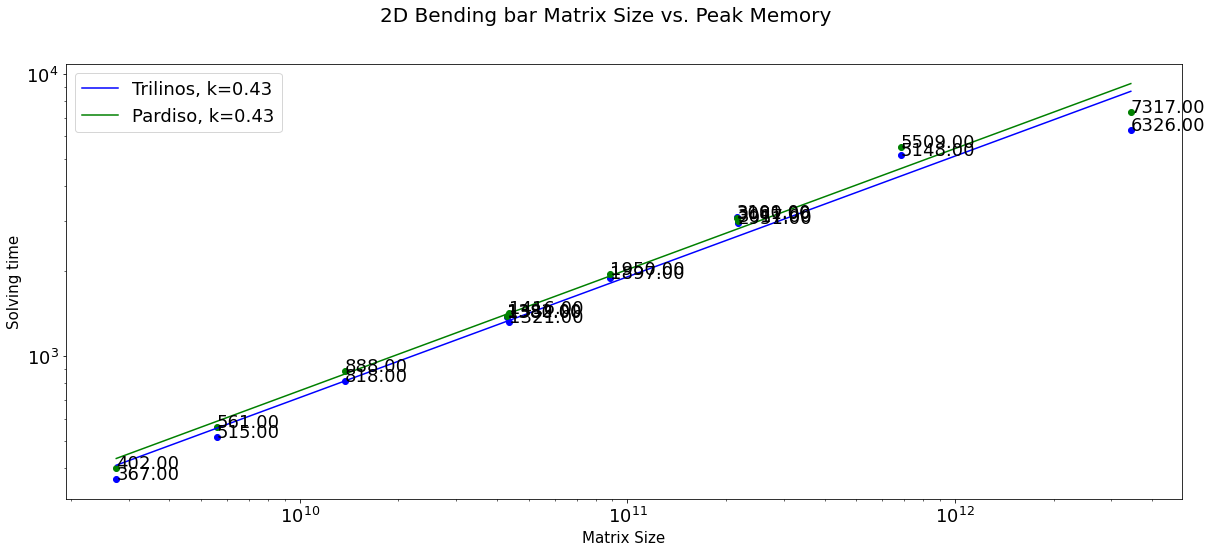

In [18]:
from matplotlib.ticker import MaxNLocator
# ml=[4,6,9,12,17]
cmap=['b','g','r','c','m','y','k','blueviolet','chartreuse']
cons=[[0.00,0.99],[0.05,0.08,0.11,0.14,0.17,0.20]]
# cons=[0.17]
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
    degree=1   
    if mesh_==None:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mat Size"]>1e8)]
    else:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_) & \
            (df["Mat Size"]>1e8)]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["n_ref"])==1]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]=="square_beam2d_2.5")]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.int64(tempdf['Mat Size'])
    ydata=np.float64(tempdf["Peak Memory"])
    logx = np.log(xdata)
    logy = np.log(ydata)
    coeffs = np.polyfit(logx,logy,deg=degree)
    poly = np.poly1d(coeffs)
    yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    # ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
    for i in range(len(xdata)):
        ax_.annotate('%.2f'%ydata[i], (xdata[i], ydata[i]))

solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLLT","Trilinos"]

fig,ax=plt.subplots(1,1,figsize=(20,8)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
label=""
data_frame=None

fit("Trilinos","Trilinos",2,ax,bar_df,cmap,0)
fit("Eigen::PardisoLLT","Pardiso",2,ax,bar_df,cmap,1)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.set_ylabel("Solving time",fontsize=15) # y labels
ax.set_xlabel("Matrix Size",fontsize=15) # x labels
plt.suptitle("2D Bending bar Matrix Size vs. Peak Memory",fontsize=20) # title

Text(0.5, 0.98, '2D Bending bar Matrix Size vs. Iterations')

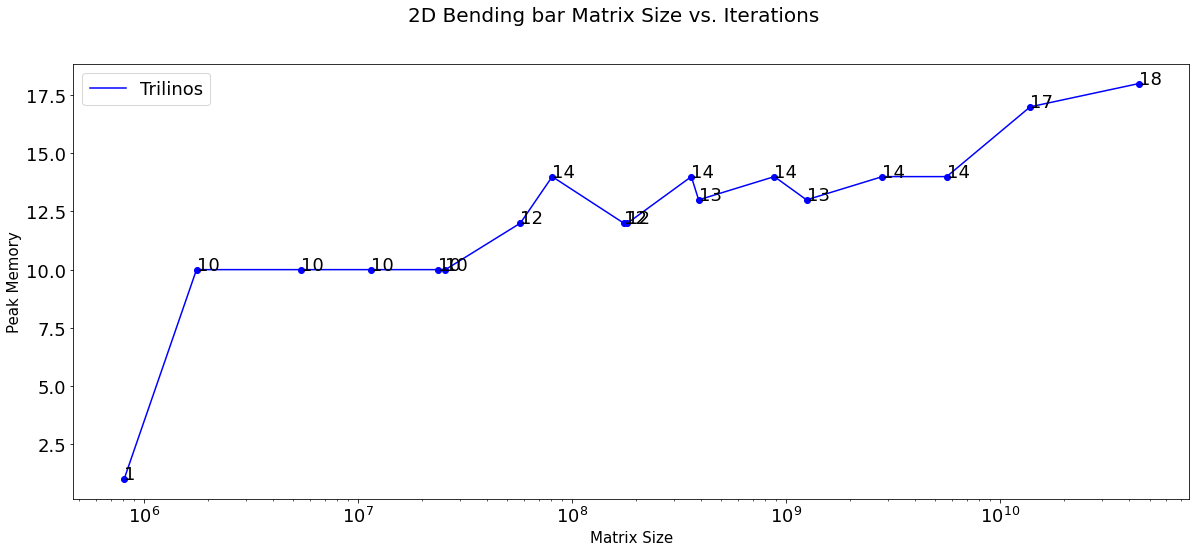

In [23]:
from matplotlib.ticker import MaxNLocator
# ml=[4,6,9,12,17]
cmap=['b','g','r','c','m','y','k','blueviolet','chartreuse']
cons=[[0.00,0.99],[0.05,0.08,0.11,0.14,0.17,0.20]]
# cons=[0.17]
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
    degree=1   
    if mesh_==None:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1)]
    else:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_)]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["n_ref"])==1]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]=="square_beam2d_2.5")]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.int64(tempdf['Mat Size'])
    ydata=np.float64(tempdf["Iterations"])
    logx = np.log(xdata)
    logy = np.log(ydata)
    coeffs = np.polyfit(logx,logy,deg=degree)
    poly = np.poly1d(coeffs)
    yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
    for i in range(len(xdata)):
        ax_.annotate('%d'%ydata[i], (xdata[i], ydata[i]))

solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLLT","Trilinos"]

fig,ax=plt.subplots(1,1,figsize=(20,8)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
label=""
data_frame=None

fit("Trilinos","Trilinos",2,ax,bar_df,cmap,0)
ax.legend()
# ax.set_yscale('log')
ax.set_xscale('log')
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.set_ylabel("Peak Memory",fontsize=15) # y labels
ax.set_xlabel("Matrix Size",fontsize=15) # x labels
plt.suptitle("2D Bending bar Matrix Size vs. Iterations",fontsize=20) # title

Text(0.5, 0.98, '3D Bending bar Matrix Size vs. Solving time')

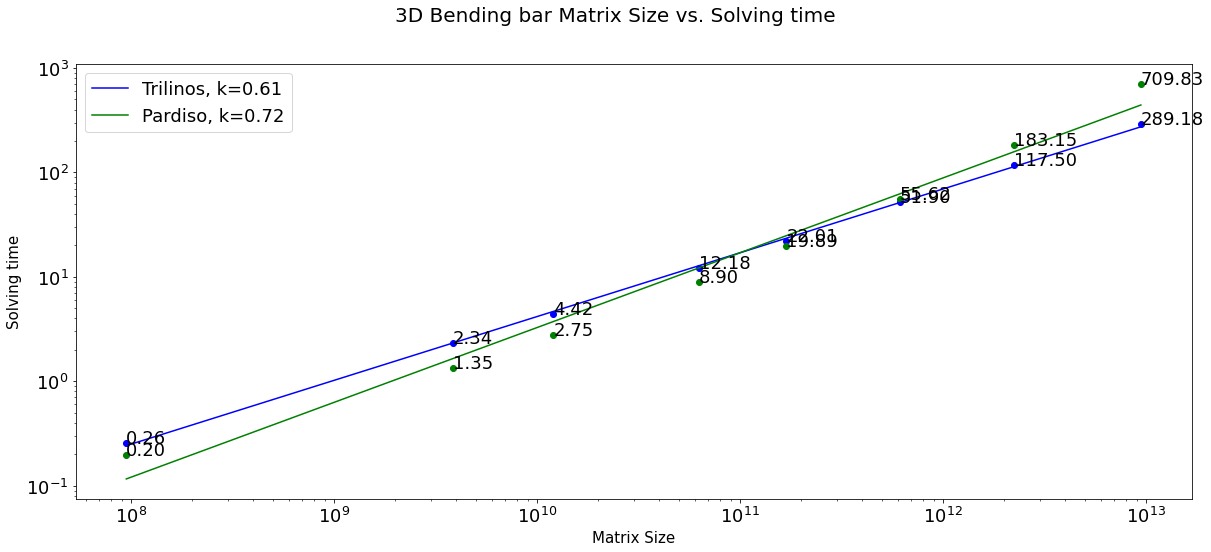

In [21]:
from matplotlib.ticker import MaxNLocator
# ml=[4,6,9,12,17]
cmap=['b','g','r','c','m','y','k','blueviolet','chartreuse']
cons=[[0.00,0.99],[0.05,0.08,0.11,0.14,0.17,0.20]]
# cons=[0.17]
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
    degree=1   
    if mesh_==None:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) ]
    else:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_)]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["n_ref"])==1]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]=="square_beam2d_2.5")]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.int64(tempdf['Mat Size'])
    ydata=np.float64(tempdf["Runtime"])
    logx = np.log(xdata)
    logy = np.log(ydata)
    coeffs = np.polyfit(logx,logy,deg=degree)
    poly = np.poly1d(coeffs)
    yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    # ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
    for i in range(len(xdata)):
        ax_.annotate('%.2f'%ydata[i], (xdata[i], ydata[i]))

solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLLT","Trilinos"]

fig,ax=plt.subplots(1,1,figsize=(20,8)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
label=""
data_frame=None

fit("Trilinos","Trilinos",3,ax,bar_3d_df,cmap,0)
fit("Eigen::PardisoLLT","Pardiso",3,ax,bar_3d_df,cmap,1)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.set_ylabel("Solving time",fontsize=15) # y labels
ax.set_xlabel("Matrix Size",fontsize=15) # x labels
plt.suptitle("3D Bending bar Matrix Size vs. Solving time",fontsize=20) # title

In [10]:
unstruct_2d_list,_=data_collect([glob.glob("/home/yiwei/results_null_test/2d/unstruct/norefine/**/**/**/**/**/**/**"),glob.glob("/home/yiwei/results_null_test/2d/unstruct/refine/**/**/**/**/**/**/**")],7)
unstruct_2d_df=df_create(unstruct_2d_list)
unstruct_3d_list,_=data_collect([glob.glob("/home/yiwei/results_null_test/3d/unstruct/norefine/**/**/**/**/**/**/**"),glob.glob("/home/yiwei/results_null_test/3d/unstruct/refine/**/**/**/**/**/**/**")],7)
unstruct_3d_df=df_create(unstruct_3d_list)
struct_2d_list,_=data_collect([glob.glob("/home/yiwei/results_null_test/2d/struct/norefine/**/**/**/**/**/**/**"),glob.glob("/home/yiwei/results_null_test/2d/struct/refine/**/**/**/**/**/**/**")],7)
struct_2d_df=df_create(struct_2d_list)
struct_3d_list,_=data_collect([glob.glob("/home/yiwei/results_null_test/3d/struct/norefine/**/**/**/**/**/**/**"),glob.glob("/home/yiwei/results_null_test/3d/struct/refine/**/**/**/**/**/**/**")],7)
struct_3d_df=df_create(struct_3d_list)

coarse_unstruct_2d_list,_=data_collect([glob.glob("/home/yiwei/results_null/2d/unstruct/norefine/**/**/**/**/**/**/**"),glob.glob("/home/yiwei/results_null/2d/unstruct/refine/**/**/**/**/**/**/**")],7)
coarse_unstruct_2d_df=df_create(coarse_unstruct_2d_list)
coarse_unstruct_3d_list,_=data_collect([glob.glob("/home/yiwei/results_null/3d/unstruct/norefine/**/**/**/**/**/**/**"),glob.glob("/home/yiwei/results_null/3d/unstruct/refine/**/**/**/**/**/**/**")],7)
coarse_unstruct_3d_df=df_create(coarse_unstruct_3d_list)
coarse_struct_2d_list,_=data_collect([glob.glob("/home/yiwei/results_null/2d/struct/norefine/**/**/**/**/**/**/**"),glob.glob("/home/yiwei/results_null/2d/struct/refine/**/**/**/**/**/**/**")],7)
coarse_struct_2d_df=df_create(coarse_struct_2d_list)
coarse_struct_3d_list,_=data_collect([glob.glob("/home/yiwei/results_null/3d/struct/norefine/**/**/**/**/**/**/**"),glob.glob("/home/yiwei/results_null/3d/struct/refine/**/**/**/**/**/**/**")],7)
coarse_struct_3d_df=df_create(coarse_struct_3d_list)

la_unstruct_2d_list,_=data_collect([glob.glob("/home/yiwei/results_null_la/2d/unstruct/norefine/**/**/**/**/**/**/**"),glob.glob("/home/yiwei/results_null_la/2d/unstruct/refine/**/**/**/**/**/**/**")],7)
la_unstruct_2d_df=df_create(la_unstruct_2d_list)
la_unstruct_3d_list,_=data_collect([glob.glob("/home/yiwei/results_null_la/3d/unstruct/norefine/**/**/**/**/**/**/**"),glob.glob("/home/yiwei/results_null_la/3d/unstruct/refine/**/**/**/**/**/**/**")],7)
la_unstruct_3d_df=df_create(la_unstruct_3d_list)
la_struct_2d_list,_=data_collect([glob.glob("/home/yiwei/results_null_la/2d/struct/norefine/**/**/**/**/**/**/**"),glob.glob("/home/yiwei/results_null_la/2d/struct/refine/**/**/**/**/**/**/**")],7)
la_struct_2d_df=df_create(la_struct_2d_list)
la_struct_3d_list,_=data_collect([glob.glob("/home/yiwei/results_null_la/3d/struct/norefine/**/**/**/**/**/**/**"),glob.glob("/home/yiwei/results_null_la/3d/struct/refine/**/**/**/**/**/**/**")],7)
la_struct_3d_df=df_create(la_struct_3d_list)


In [24]:
# Sample function, redefine it when ploting
cmap=['b','g','r','c','m','y','k','blueviolet','chartreuse']
def plot(solver_name_,block_size_,ydata_,ax_,df,loc_index_,num_rects_):   
    tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)& (df["discr_order"]==1)]
    tempdf=tempdf.sort_values(by=['Num Thread'])
    xdata=np.int64(tempdf["Num Thread"])
    ydata=np.float64(tempdf[ydata_])
    if solver_name_=="Eigen::CholmodSupernodalLLT":
        label_="Cholmod"
    elif solver_name_=="Eigen::PardisoLDLT":
        label_="Pardiso"
    else:
        label_=solver_name_+"B"+str(block_size_)
    x=np.log2(xdata)
    ax_.bar_label(ax_.bar((x-0.4+0.8/num_rects_*(loc_index_+0.5)),ydata,0.8/num_rects_,color=cmap[loc_index_],label=label_),padding=3,fmt='%d',fontsize=18)
    

Text(0.5, 0.98, '2D Bending bar Iterations-Matrix Size, nullspace vectors')

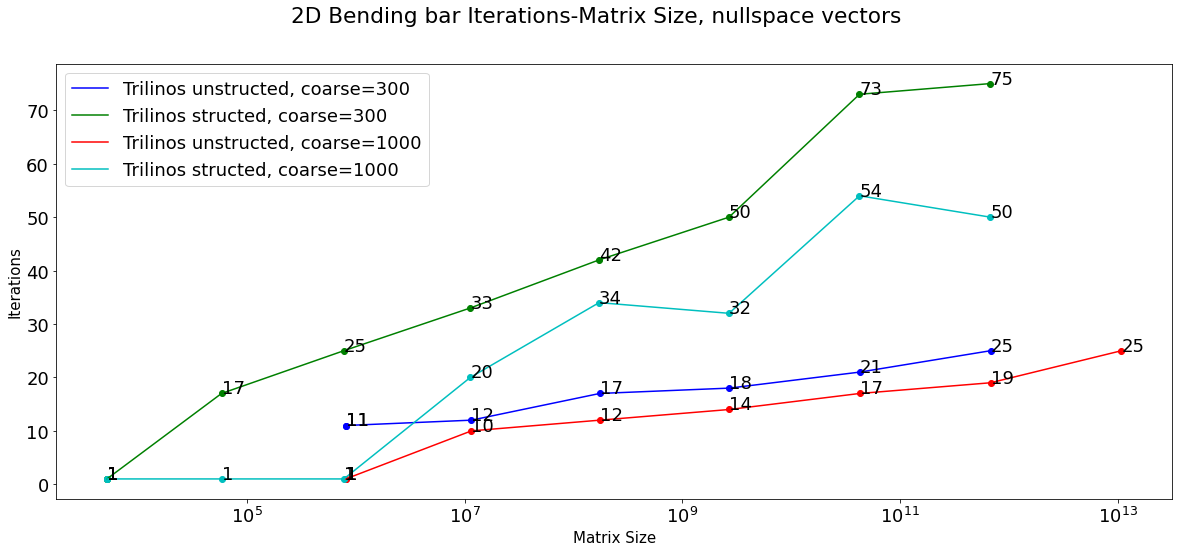

In [28]:
from matplotlib.ticker import MaxNLocator
# ml=[4,6,9,12,17]

cons=[[0.00,0.99],[0.05,0.08,0.11,0.14,0.17,0.20]]
# cons=[0.17]
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
    degree=1   
    if mesh_==None:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) &(df["n_ref"]==0)]
    else:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_)]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["n_ref"])==1]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]=="square_beam2d_2.5")]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.int64(tempdf['Mat Size'])
    ydata=np.float64(tempdf["Iterations"])
    # logx = np.log(xdata)
    # logy = np.log(ydata)
    # coeffs = np.polyfit(logx,logy,deg=degree)
    # poly = np.poly1d(coeffs)
    # yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
    for i in range(len(xdata)):
        ax_.annotate('%d'%ydata[i], (xdata[i], ydata[i]))

solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT","Trilinos"]

num_threads=np.sort(np.int64(unstruct_2d_df["Num Thread"].unique()))
fig,ax=plt.subplots(1,1,figsize=(20,8)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
label=""
data_frame=None

fit("Trilinos","Trilinos unstructed, coarse=300",2,ax,unstruct_2d_df,cmap,0,"square_beam2d_2.5")
fit("Trilinos","Trilinos structed, coarse=300",2,ax,struct_2d_df,cmap,1,"square_beam2d_struct_5")
fit("Trilinos","Trilinos unstructed, coarse=1000",2,ax,coarse_unstruct_2d_df,cmap,2,"square_beam2d_2.5")
fit("Trilinos","Trilinos structed, coarse=1000",2,ax,coarse_struct_2d_df,cmap,3,"square_beam2d_struct_5")
# fit("Trilinos","Trilinos unstructed",2,ax,unstruct_2d_df,cmap,0,"square_beam2d_2.5")
# fit("Trilinos","Trilinos structed",2,ax,struct_2d_df,cmap,1,"square_beam2d_struct_5")
# fit("Hypre","Hypre",1,ax,laplace3d_tet,cmap,1)
# fit("Trilinos","Trilinos",1,ax,laplace3d_tet,cmap,2)
ax.legend()
ax.set_xscale('log')
# fit("Hypre",3,ax,result_df,cmap,3)
# fit("Eigen::CholmodSupernodalLLT",1,ax,result_df,cmap,4)
# fit("Eigen::PardisoLDLT",1,ax,result_df,cmap,5)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.set_ylabel("Iterations",fontsize=15) # y labels
ax.set_xlabel("Matrix Size",fontsize=15) # x labels
plt.suptitle("2D Bending bar Iterations-Matrix Size, nullspace vectors")

Text(0.5, 0.98, '3D Bending bar Iterations-Matrix Size, nullspace vectors')

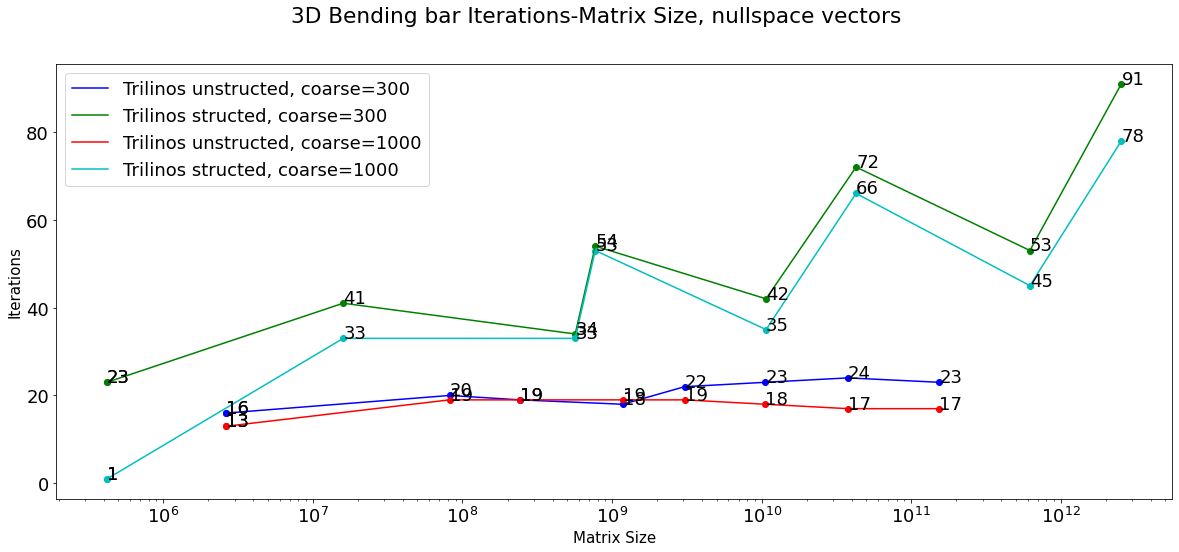

In [27]:
from matplotlib.ticker import MaxNLocator
# ml=[4,6,9,12,17]

cons=[[0.00,0.99],[0.05,0.08,0.11,0.14,0.17,0.20]]
# cons=[0.17]
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
    degree=1   
    if mesh_==None:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) &(df["n_ref"]==0)]
    else:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_)]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["n_ref"])==1]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]=="square_beam2d_2.5")]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.int64(tempdf['Mat Size'])
    ydata=np.float64(tempdf["Iterations"])
    # logx = np.log(xdata)
    # logy = np.log(ydata)
    # coeffs = np.polyfit(logx,logy,deg=degree)
    # poly = np.poly1d(coeffs)
    # yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
    for i in range(len(xdata)):
        ax_.annotate('%d'%ydata[i], (xdata[i], ydata[i]))

solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT","Trilinos"]

num_threads=np.sort(np.int64(unstruct_3d_df["Num Thread"].unique()))
fig,ax=plt.subplots(1,1,figsize=(20,8)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
label=""
data_frame=None

fit("Trilinos","Trilinos unstructed, coarse=300",3,ax,unstruct_3d_df,cmap,0)
fit("Trilinos","Trilinos structed, coarse=300",3,ax,struct_3d_df,cmap,1)
fit("Trilinos","Trilinos unstructed, coarse=1000",3,ax,coarse_unstruct_3d_df,cmap,2)
fit("Trilinos","Trilinos structed, coarse=1000",3,ax,coarse_struct_3d_df,cmap,3)
# fit("Trilinos","Trilinos unstructed",3,ax,unstruct_3d_df,cmap,0,"square_beam_5.00")
# fit("Trilinos","Trilinos structed",3,ax,struct_3d_df,cmap,1,"square_beam_struct_5")
# fit("Hypre","Hypre",1,ax,laplace3d_tet,cmap,1)
# fit("Trilinos","Trilinos",1,ax,laplace3d_tet,cmap,2)
ax.legend()
ax.set_xscale('log')
# fit("Hypre",3,ax,result_df,cmap,3)
# fit("Eigen::CholmodSupernodalLLT",1,ax,result_df,cmap,4)
# fit("Eigen::PardisoLDLT",1,ax,result_df,cmap,5)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.set_ylabel("Iterations",fontsize=15) # y labels
ax.set_xlabel("Matrix Size",fontsize=15) # x labels
plt.suptitle("3D Bending bar Iterations-Matrix Size, nullspace vectors")

Text(0.5, 0.98, '3D bar laplace problem')

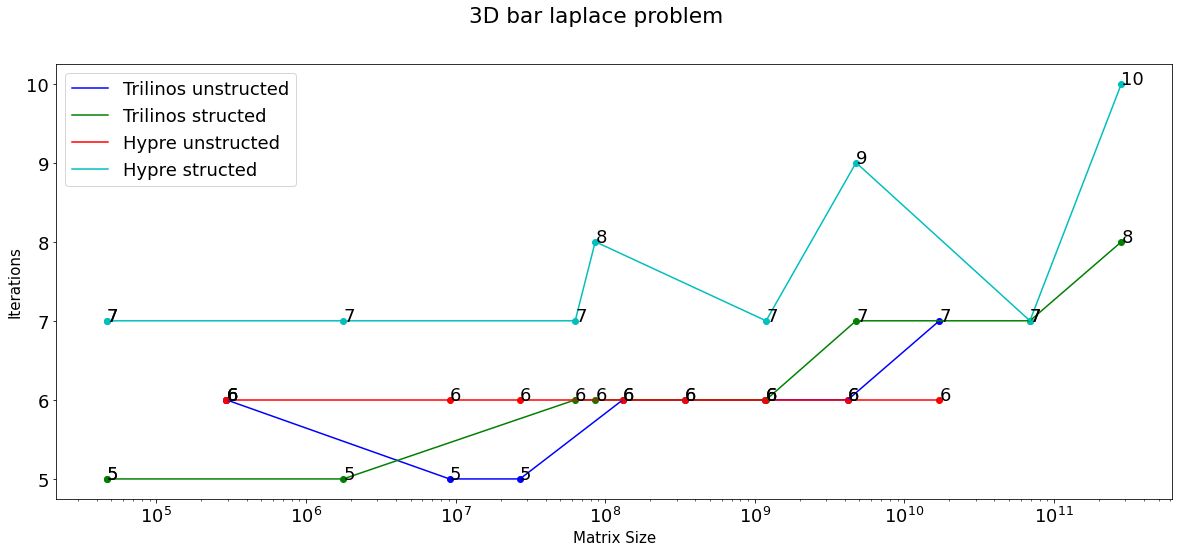

In [57]:
from matplotlib.ticker import MaxNLocator
# ml=[4,6,9,12,17]

cons=[[0.00,0.99],[0.05,0.08,0.11,0.14,0.17,0.20]]
# cons=[0.17]
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
    degree=1   
    if mesh_==None:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) &(df["n_ref"]==0)]
    else:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_)]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["n_ref"])==1]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]=="square_beam2d_2.5")]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.int64(tempdf['Mat Size'])
    ydata=np.float64(tempdf["Iterations"])
    # logx = np.log(xdata)
    # logy = np.log(ydata)
    # coeffs = np.polyfit(logx,logy,deg=degree)
    # poly = np.poly1d(coeffs)
    # yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
    for i in range(len(xdata)):
        ax_.annotate('%d'%ydata[i], (xdata[i], ydata[i]))

solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT","Trilinos"]

num_threads=np.sort(np.int64(unstruct_3d_df["Num Thread"].unique()))
fig,ax=plt.subplots(1,1,figsize=(20,8)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
label=""
data_frame=None

fit("Trilinos","Trilinos unstructed",1,ax,la_unstruct_3d_df,cmap,0)
fit("Trilinos","Trilinos structed",1,ax,la_struct_3d_df,cmap,1)
fit("Hypre","Hypre unstructed",1,ax,la_unstruct_3d_df,cmap,2)
fit("Hypre","Hypre structed",1,ax,la_struct_3d_df,cmap,3)
ax.legend()
ax.set_xscale('log')
# fit("Hypre",3,ax,result_df,cmap,3)
# fit("Eigen::CholmodSupernodalLLT",1,ax,result_df,cmap,4)
# fit("Eigen::PardisoLDLT",1,ax,result_df,cmap,5)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.set_ylabel("Iterations",fontsize=15) # y labels
ax.set_xlabel("Matrix Size",fontsize=15) # x labels
plt.suptitle("3D bar laplace problem")

Text(0.5, 0.98, '2D bar laplace problem')

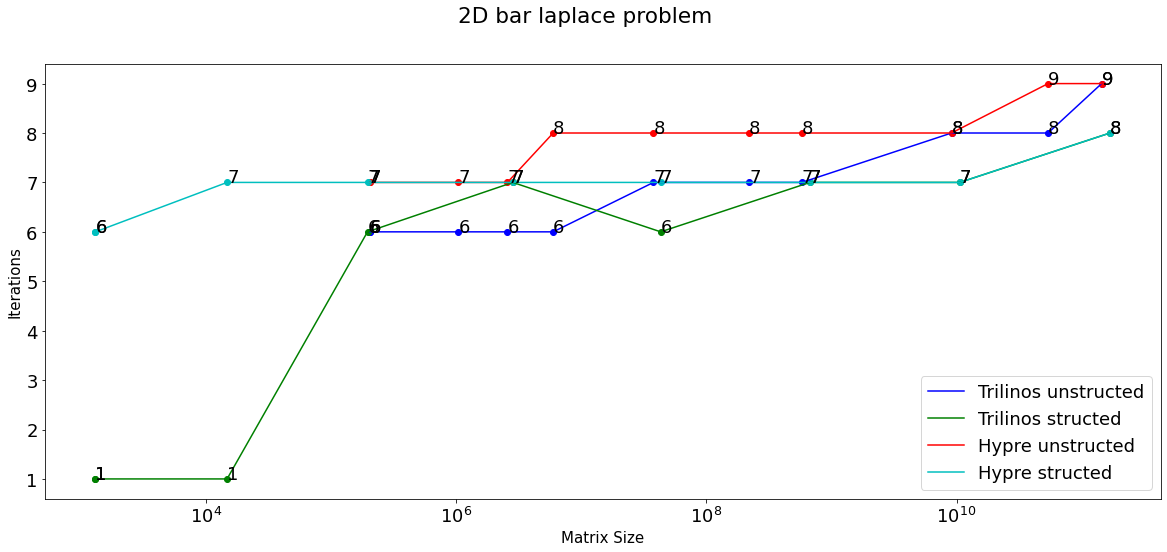

In [56]:
from matplotlib.ticker import MaxNLocator
# ml=[4,6,9,12,17]

cons=[[0.00,0.99],[0.05,0.08,0.11,0.14,0.17,0.20]]
# cons=[0.17]
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_,mesh_=None):
    degree=1   
    if mesh_==None:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) &(df["n_ref"]==0)]
    else:
        tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]==mesh_)]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["n_ref"])==1]
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_) &(df["discr_order"]==1) & (df["Mesh"]=="square_beam2d_2.5")]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.int64(tempdf['Mat Size'])
    ydata=np.float64(tempdf["Iterations"])
    # logx = np.log(xdata)
    # logy = np.log(ydata)
    # coeffs = np.polyfit(logx,logy,deg=degree)
    # poly = np.poly1d(coeffs)
    # yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
    for i in range(len(xdata)):
        ax_.annotate('%d'%ydata[i], (xdata[i], ydata[i]))

solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT","Trilinos"]

num_threads=np.sort(np.int64(unstruct_3d_df["Num Thread"].unique()))
fig,ax=plt.subplots(1,1,figsize=(20,8)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
label=""
data_frame=None

fit("Trilinos","Trilinos unstructed",1,ax,la_unstruct_2d_df,cmap,0)
fit("Trilinos","Trilinos structed",1,ax,la_struct_2d_df,cmap,1)
fit("Hypre","Hypre unstructed",1,ax,la_unstruct_2d_df,cmap,2)
fit("Hypre","Hypre structed",1,ax,la_struct_2d_df,cmap,3)
# fit("Trilinos","Trilinos",1,ax,laplace3d_tet,cmap,2)
ax.legend()
ax.set_xscale('log')
# fit("Hypre",3,ax,result_df,cmap,3)
# fit("Eigen::CholmodSupernodalLLT",1,ax,result_df,cmap,4)
# fit("Eigen::PardisoLDLT",1,ax,result_df,cmap,5)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.set_ylabel("Iterations",fontsize=15) # y labels
ax.set_xlabel("Matrix Size",fontsize=15) # x labels
plt.suptitle("2D bar laplace problem")

Text(0.5, 0.98, 'Laplace 3d Iterations-Mesh Size, hex struct')

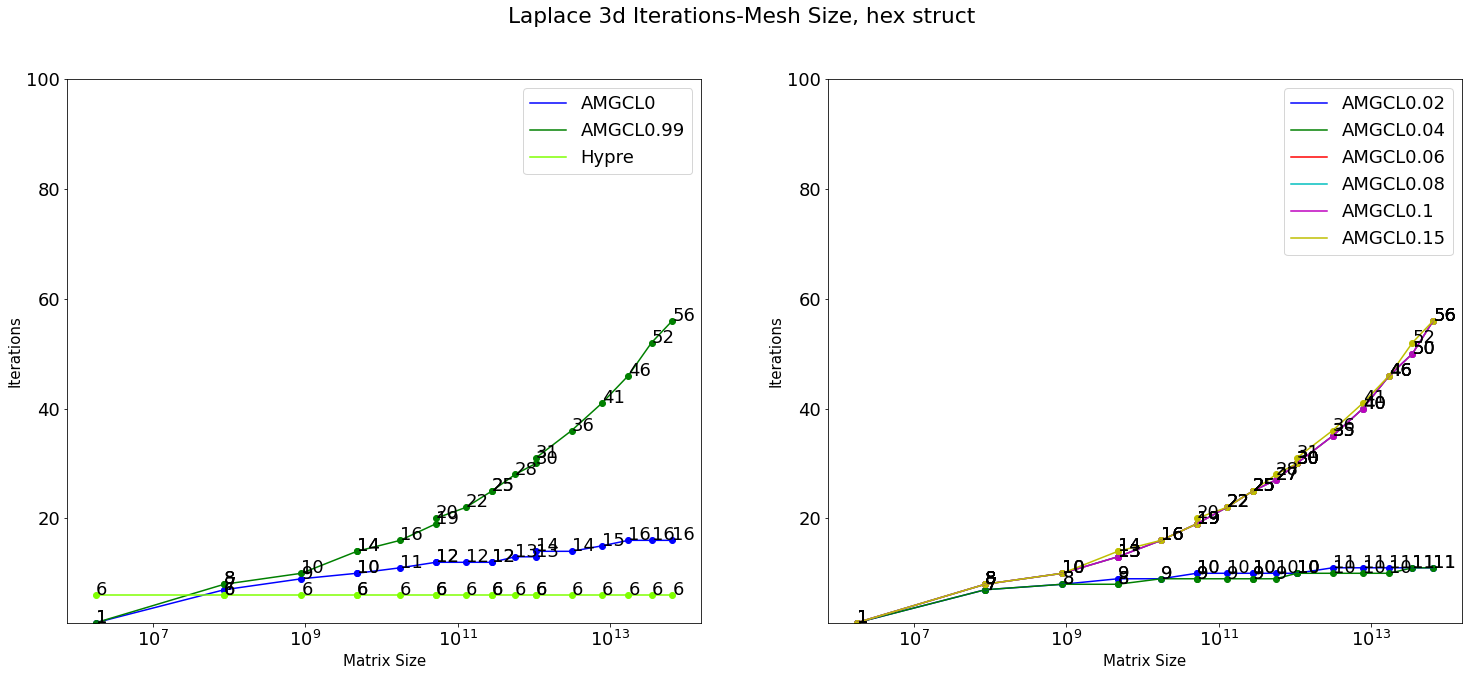

In [16]:
from matplotlib.ticker import MaxNLocator
# ml=[4,6,9,12,17]

cons=[[0,0.99],[0.02,0.04,0.06,0.08,0.10,0.15]]
# cons=[0.17]
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_):
    degree=1    
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)]
    tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)&(df["discr_order"]==2)]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.int64(tempdf['Mat Size'])
    ydata=np.float64(tempdf["Iterations"])
    # logx = np.log(xdata)
    # logy = np.log(ydata)
    # coeffs = np.polyfit(logx,logy,deg=degree)
    # poly = np.poly1d(coeffs)
    # yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
    for i in range(len(xdata)):
        ax_.annotate('%d'%ydata[i], (xdata[i], ydata[i]))

solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]

num_threads=np.sort(np.int64(laplace2d_quad["Num Thread"].unique()))
fig,ax=plt.subplots(1,2,figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
label=""
data_frame=None

for i in range(2):
    iter=0
    con=cons[i]    
    for j in con:
        ax[i].set_ylabel("Iterations",fontsize=15) # y labels
        ax[i].set_xlabel("Matrix Size",fontsize=15) # y labels
        ax[i].set_ylim(1,100)
        # ax[i].set_yscale('log')
        ax[i].set_xscale('log')
        fit("AMGCL_"+str(j),"AMGCL"+str(j),1,ax[i],laplace3d_hex,cmap,iter)
        # fit("AMGCL_0.08","AMGCL_0.08"+label,1,ax[i],data_frame,cmap,1)
        iter=iter+1

# fit("AMGCL","ML",1,ax,laplace3d,cmap,2)
# fit("AMGCL",3,ax,result_df,cmap,1)
fit("Hypre","Hypre"+label,1,ax[0],laplace3d_hex,cmap,8)
ax[0].legend()
ax[1].legend()
# fit("Hypre",3,ax,result_df,cmap,3)
# fit("Eigen::CholmodSupernodalLLT",1,ax,result_df,cmap,4)
# fit("Eigen::PardisoLDLT",1,ax,result_df,cmap,5)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plt.suptitle("Laplace 3d Iterations-Mesh Size, hex struct")
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xscale("log") # log scale
# plt.yscale("log") # log scale

# ax.set_xticks([1,2,4,8,16,32,64],[str(1),str(2),str(4),str(8),str(16),str(32),str(64)])

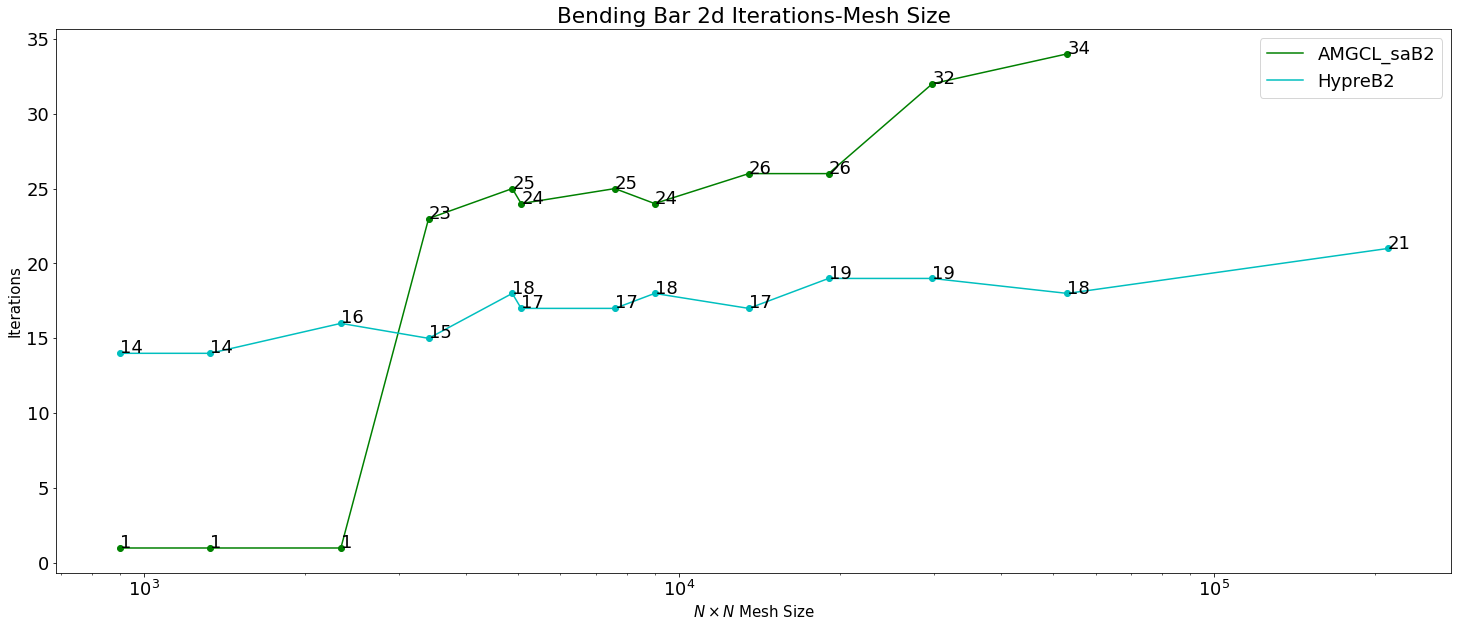

In [22]:
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_):
    degree=1    
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)]
    tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)& (df["discr_order"]==1)]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.sqrt(np.int64(tempdf['Mat Size']))
    ydata=np.float64(tempdf["Iterations"])
    # logx = np.log(xdata)
    # logy = np.log(ydata)
    # coeffs = np.polyfit(logx,logy,deg=degree)
    # poly = np.poly1d(coeffs)
    # yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
    for i in range(len(xdata)):
        ax_.annotate('%d'%ydata[i], (xdata[i], ydata[i]))

solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]

num_threads=np.sort(np.int64(bar2d["Num Thread"].unique()))
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel(r'$N \times N$ Mesh Size',fontsize=15) # x labels
ax.set_ylabel("Iterations",fontsize=15) # y labels
# fit("AMGCL_sa","AMGCL_saB1",1,ax,bar2d,cmap,0)
fit("AMGCL_sa","AMGCL_saB2",2,ax,bar2d,cmap,1)
# fit("Hypre","HypreB1",1,ax,bar2d,cmap,2)
fit("Hypre","HypreB2",2,ax,bar2d,cmap,3)
# fit("AMGCL","AMGCL_rsB1",1,ax,bar2d,cmap,4)

# fit("Hypre",3,ax,result_df,cmap,3)
# fit("Eigen::CholmodSupernodalLLT",1,ax,result_df,cmap,4)
# fit("Eigen::PardisoLDLT",1,ax,result_df,cmap,5)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plt.title("Bending Bar 2d Iterations-Mesh Size")
plt.xscale("log") # log scale
# plt.yscale("log") # log scale
ax.legend()
# ax.set_xticks([1,2,4,8,16,32,64],[str(1),str(2),str(4),str(8),str(16),str(32),str(64)])

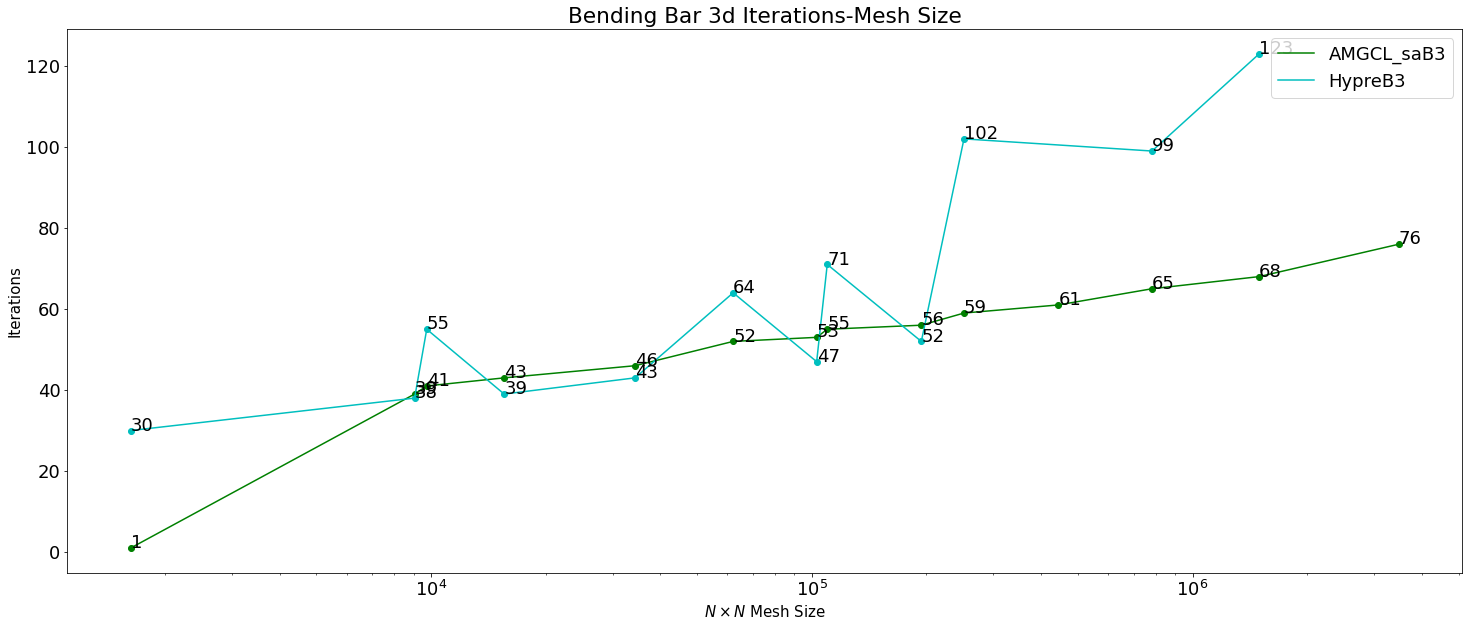

In [23]:
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_):
    degree=1    
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)]
    tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)& (df["discr_order"]==1)]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.sqrt(np.int64(tempdf['Mat Size']))
    ydata=np.float64(tempdf["Iterations"])
    # logx = np.log(xdata)
    # logy = np.log(ydata)
    # coeffs = np.polyfit(logx,logy,deg=degree)
    # poly = np.poly1d(coeffs)
    # yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
    for i in range(len(xdata)):
        ax_.annotate('%d'%ydata[i], (xdata[i], ydata[i]))

solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]

num_threads=np.sort(np.int64(bar3d["Num Thread"].unique()))
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel(r'$N \times N$ Mesh Size',fontsize=15) # x labels
ax.set_ylabel("Iterations",fontsize=15) # y labels
# fit("AMGCL_sa","AMGCL_saB1",1,ax,bar3d,cmap,0)
fit("AMGCL_sa","AMGCL_saB3",3,ax,bar3d,cmap,1)
# fit("Hypre","HypreB1",1,ax,bar3d,cmap,2)
fit("Hypre","HypreB3",3,ax,bar3d,cmap,3)
# fit("AMGCL",3,ax,result_df,cmap,1)

# fit("Hypre",3,ax,result_df,cmap,3)
# fit("Eigen::CholmodSupernodalLLT",1,ax,result_df,cmap,4)
# fit("Eigen::PardisoLDLT",1,ax,result_df,cmap,5)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plt.title("Bending Bar 3d Iterations-Mesh Size")
plt.xscale("log") # log scale
# plt.yscale("log") # log scale
ax.legend()
# ax.set_xticks([1,2,4,8,16,32,64],[str(1),str(2),str(4),str(8),str(16),str(32),str(64)])

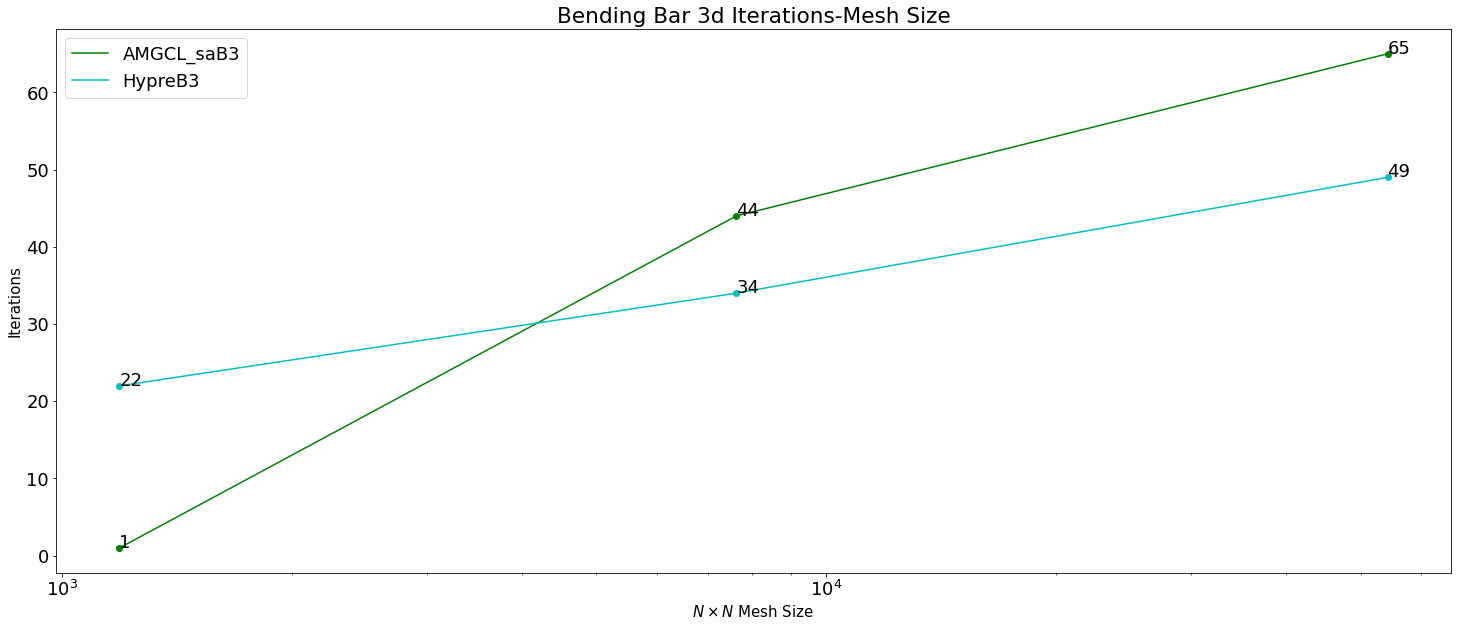

In [24]:
def fit(solver_name_,solverlabel_,block_size_,ax_,df,cmap_,cindex_):
    degree=1    
    # tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)]
    tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)& (df["discr_order"]==1)]
    tempdf=tempdf.sort_values(by=['Mat Size'])
    xdata=np.sqrt(np.int64(tempdf['Mat Size']))
    ydata=np.float64(tempdf["Iterations"])
    # logx = np.log(xdata)
    # logy = np.log(ydata)
    # coeffs = np.polyfit(logx,logy,deg=degree)
    # poly = np.poly1d(coeffs)
    # yfit = lambda x: np.exp(poly(np.log(x)))
    label_=solverlabel_
    # ax_.scatter(xdata,ydata,label=label_,color=cmap_[cindex_])
    ax_.scatter(xdata,ydata,color=cmap_[cindex_])
    # label_=label_+", k="+str("%.2f" % coeffs[degree-1])
    # ax_.plot(xdata,yfit(xdata),label=label_,color=cmap_[cindex_])
    ax_.plot(xdata,ydata,color=cmap_[cindex_],label=label_)
    for i in range(len(xdata)):
        ax_.annotate('%d'%ydata[i], (xdata[i], ydata[i]))

solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]

num_threads=np.sort(np.int64(bar3d["Num Thread"].unique()))
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel(r'$N \times N$ Mesh Size',fontsize=15) # x labels
ax.set_ylabel("Iterations",fontsize=15) # y labels
# fit("AMGCL_sa","AMGCL_saB1",1,ax,bar3d,cmap,0)
fit("AMGCL","AMGCL_saB3",3,ax,bar3d_stru,cmap,1)
# fit("Hypre","HypreB1",1,ax,bar3d,cmap,2)
fit("Hypre","HypreB3",3,ax,bar3d_stru,cmap,3)
# fit("AMGCL",3,ax,result_df,cmap,1)

# fit("Hypre",3,ax,result_df,cmap,3)
# fit("Eigen::CholmodSupernodalLLT",1,ax,result_df,cmap,4)
# fit("Eigen::PardisoLDLT",1,ax,result_df,cmap,5)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plt.title("Bending Bar 3d Iterations-Mesh Size")
plt.xscale("log") # log scale
# plt.yscale("log") # log scale
ax.legend()
# ax.set_xticks([1,2,4,8,16,32,64],[str(1),str(2),str(4),str(8),str(16),str(32),str(64)])

# Bar

/tmp/ipykernel_3487176/170077153.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,1,2,4,8,16,32,64])


[Text(-1.0, 0, '0'),
 Text(0.0, 0, '1'),
 Text(1.0, 0, '2'),
 Text(2.0, 0, '4'),
 Text(3.0, 0, '8'),
 Text(4.0, 0, '16'),
 Text(5.0, 0, '32'),
 Text(6.0, 0, '64'),
 Text(7.0, 0, '')]

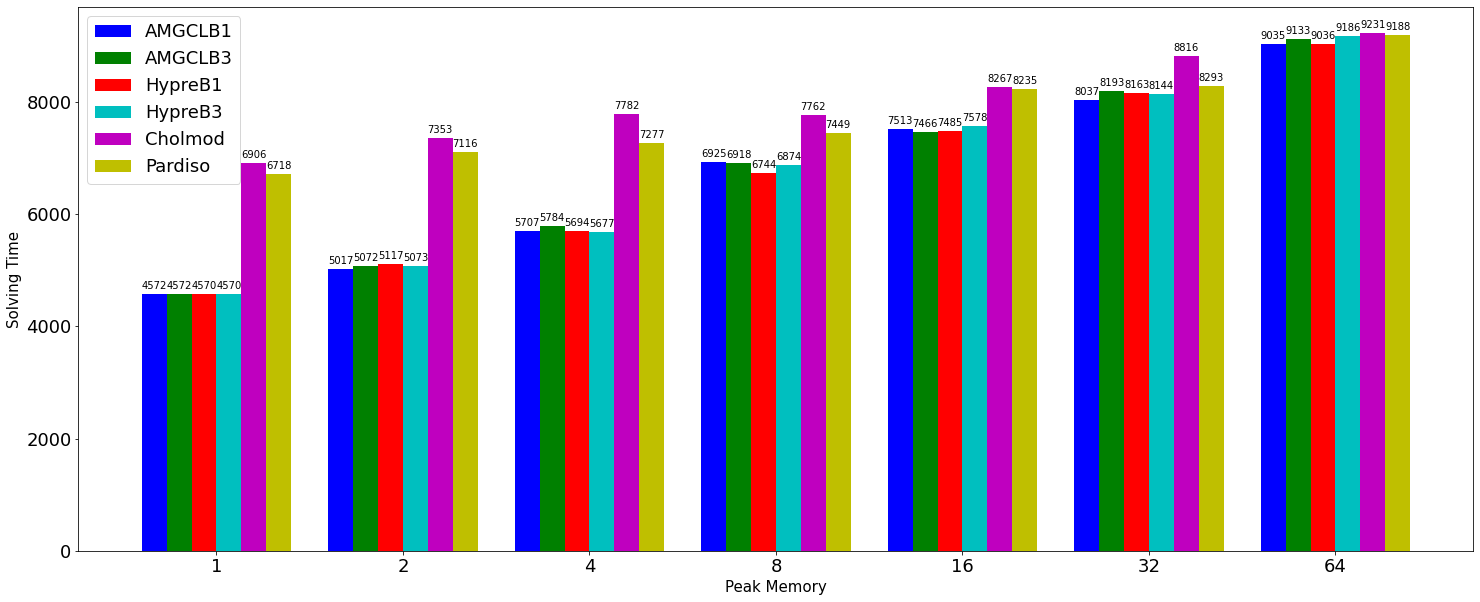

In [ ]:
%matplotlib inline
def plot(solver_name_,block_size_,ydata_,ax_,df,loc_index_,num_rects_):   
    tempdf=df[(df["Block Size"]==block_size_) & (df["Solver"]==solver_name_)& (df["discr_order"]==1)]
    tempdf=tempdf.sort_values(by=['Num Thread'])
    xdata=np.int64(tempdf["Num Thread"])
    ydata=np.float64(tempdf[ydata_])
    if solver_name_=="Eigen::CholmodSupernodalLLT":
        label_="Cholmod"
    elif solver_name_=="Eigen::PardisoLDLT":
        label_="Pardiso"
    else:
        label_=solver_name_+"B"+str(block_size_)
    x=np.log2(xdata)
    ax_.bar_label(ax_.bar((x-0.4+0.8/num_rects_*(loc_index_+0.5)),ydata,0.8/num_rects_,color=cmap[loc_index_],label=label_),padding=3,fmt='%d',fontsize=10)

solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]
cmap=['b','g','r','c','m','y','k','w']
num_threads=np.sort(np.int64(unstruct_df["Num Thread"].unique()))
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel("Peak Memory",fontsize=15) # x labels
ax.set_ylabel("Solving Time",fontsize=15) # y labels
plot("AMGCL",1,"Peak Memory",ax,unstruct_df,0,6)
plot("AMGCL",3,"Peak Memory",ax,unstruct_df,1,6)
plot("Hypre",1,"Peak Memory",ax,unstruct_df,2,6)
plot("Hypre",3,"Peak Memory",ax,unstruct_df,3,6)
plot("Eigen::CholmodSupernodalLLT",1,"Peak Memory",ax,unstruct_df,4,6)
plot("Eigen::PardisoLDLT",1,"Peak Memory",ax,unstruct_df,5,6)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.legend()
ax.set_xticklabels([0,1,2,4,8,16,32,64])
# plt.yscale("log") # log scale

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_244241/3341035240.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,1,2,4,8,16,32,64])


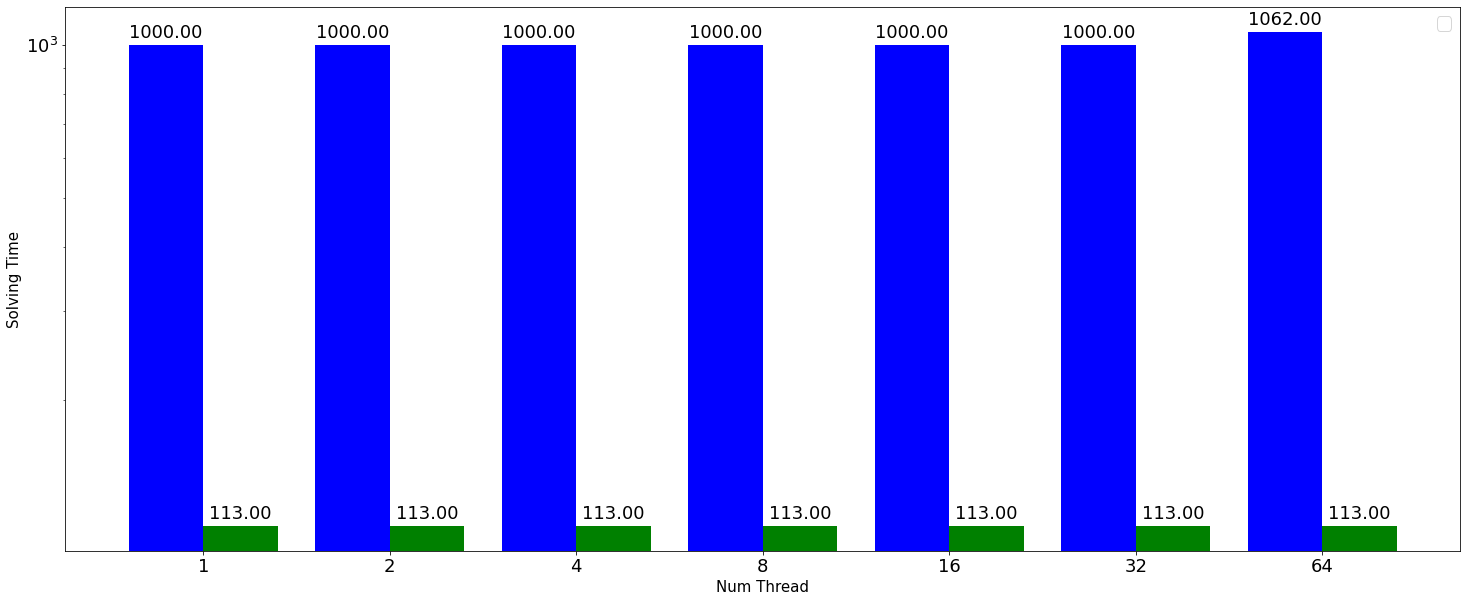

In [ ]:
%matplotlib inline
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]
cmap=['b','g','r','c','m','y','k','w']
num_threads=np.sort(np.int64(unstruct_df["Num Thread"].unique()))
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel("Num Thread",fontsize=15) # x labels
ax.set_ylabel("Solving Time",fontsize=15) # y labels
plot("Hypre",1,"Iterations",ax,unstruct_df,0,2)
plot("Hypre",3,"Iterations",ax,unstruct_df,1,2)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.legend()
ax.set_xticklabels([0,1,2,4,8,16,32,64])
plt.yscale("log") # log scale

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_244241/83242222.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,1,2,4,8,16,32,64])


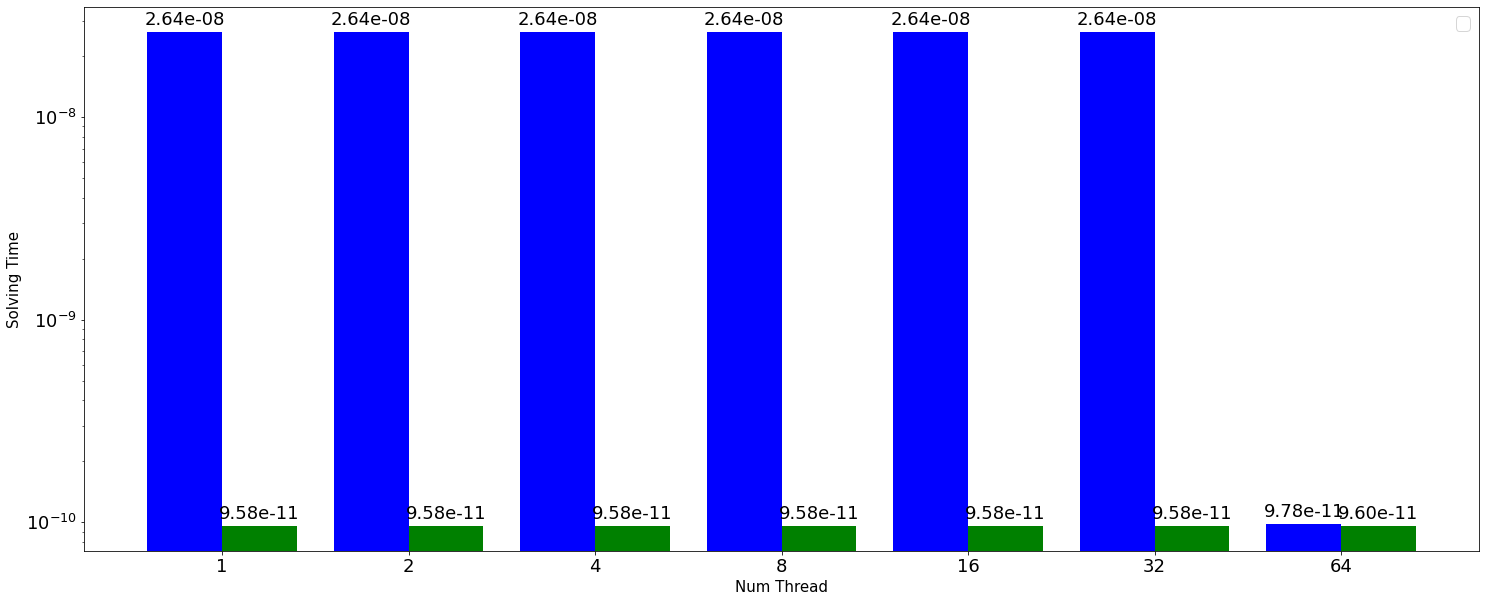

In [ ]:
%matplotlib inline
solver_list=["AMGCL","Hypre","Eigen::CholmodSupernodalLLT","Eigen::PardisoLDLT"]
cmap=['b','g','r','c','m','y','k','w']
num_threads=np.sort(np.int64(unstruct_df["Num Thread"].unique()))
fig,ax=plt.subplots(figsize=(25,10)) # figure size
plt.rcParams.update({'font.size': 18}) # font size
ax.set_xlabel("Num Thread",fontsize=15) # x labels
ax.set_ylabel("Solving Time",fontsize=15) # y labels
plot("Hypre",1,"Error",ax,unstruct_df,0,2)
plot("Hypre",3,"Error",ax,unstruct_df,1,2)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
ax.legend()
ax.set_xticklabels([0,1,2,4,8,16,32,64])
plt.yscale("log") # log scale